Библиотеки, которые используются в решении:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import time
%matplotlib inline

### Стыров Даниил, 307 группа.

# Практическое задание №1 по ОММ 
# Вариант №28


## Постановка задачи
Используя схему бегущего счета и итерационные методы, решить задачу:

$$
\left\{ \begin{array}{} \frac{\partial u}{\partial t} - \frac{2 u}{1 + u^{2}} 
        \frac{\partial u}{\partial x} = 0, \quad  -1 \leq x < 0, \\ u(x,0) = \cos{\frac{\pi x}{2}}, \\
    u(0,t) = 1 + \frac{1}{2} arctg\ t. \end{array} \right.
$$

## Построение характеристик

Характеристики квазилинейного уравнения переноса определяются следующими соотношениями:

$$\left\{ \begin{array}{} \frac{dt}{1}=\frac{dx}{-\frac{2u}{1+u^2}}, \\ du=0. \end{array} \right.$$

Проинтегрировав оба уравнения, получим:

$$\left\{ \begin{array}{} t-t^* = -\frac{1+u^{*2}}{2u^*} (x-x^*), \\ u=u^*=u^*(x^*,t^*). \end{array} \right.$$

Получим два семейства кривых, воспользовавшись начальным и граничным условиями:

$1. \quad t^*=0:$

$$\left\{ \begin{array}{} t=-\frac{1+(\cos{\frac{\pi x^*}{2}})^2}{2 \cos{\frac{\pi x^*}{2}}}  (x-x^*),,  \\ u^*=\cos{\frac{\pi x^*}{2}}. \end{array} \right.$$

$2. \quad x^*=0:$

$$\left\{ \begin{array}{} t=-\frac{1+(1+\frac{1}{2} arctg\ t^*)^2}{2+ arctg\ t^*}  x,  \\ u^*=1+\frac{1}{2} arctg\ t^*. \end{array} \right.$$

### Код для построения характеристик:

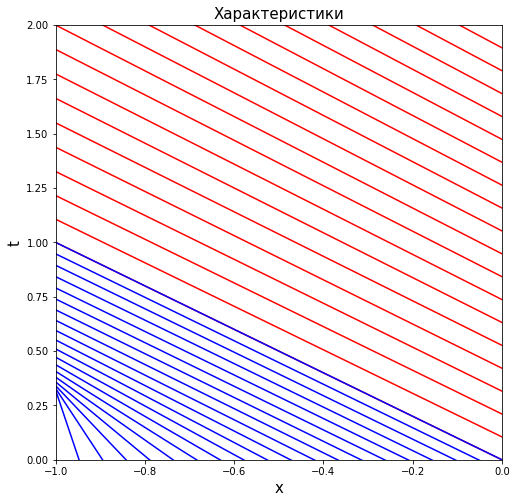

In [2]:
K = 20
x, t = np.linspace(-1, 0, K), np.linspace(0, 2, K)

def t1(x0, x):
    return  -(1 + (np.cos(np.pi*x0/2))**2)/(2*np.cos(np.pi*x0/2))*(x-x0)

def t2(t0, x):
    return t0 - (1 + (1+0.5*np.arctan(t0))**2)/(2 + np.arctan(t0))*x
    
fig = plt.figure(figsize =(8 ,8))
ax = fig.gca(xlim=(-1, 0), ylim=(0, 2)) 
plt.title('Характеристики', fontsize=15)
plt.ylabel('t', fontsize=15)
plt.xlabel('x', fontsize=15)

for i in range(K):
  ax.plot(x , t1(x[i] ,x) , color = "blue");
  ax.plot(x , t2(t[i] ,x), color = "red");

Заметим, что в области $-1 \leq x < 0$ на промежутке времени $0 < t < 1$ характеристики не пересекаются. Будем искать решение в этой области во избежание опрокидывания волны.

## Разностная сетка

Введем в расчетной области равномерную сетку:

$$\overline{\omega_{h,\tau}}=\big\{x_n= (N-1-n) h, t_m=m\tau, n=\overline{0,N-1}, m=\overline{0,M-1}\big\},$$

где $h = -\frac{1}{N-1}$, $\tau = \frac{1}{M-1}$ - шаги по координате и времени соответственно, $N,M$ - число узлов по осям $x$ и $t$ соответственно.

Перепишем исходное уравнение в дивергентном виде:

$$\frac{\partial u}{\partial t} +  
        \frac{\partial}{\partial x}(-\ln({1 + u^{2})}) = 0$$

Введем на $\overline{\omega_{h,\tau}}$ сеточную функцию: $y_n^m=u(x_n,t_m)$. Также удобно ввести вспомогательную функцию: $F_n^m=F(y_n^m)=-\ln(1+(y_n^m)^2)$

Для построения разностной схемы будем пользоваться трёхточечным шаблоном вида: 

<center><img src=https://i.imgur.com/UQXGajP.png="130"></center>

Для линейного уравнения переноса он является абсолютно устойчивым, а разностный оператор аппроксимирует дифференциальный с первым порядком точности $O(h+\tau)$. 

Разностная схема для исходной задачи имеет следующий вид:

$$\left\{ \begin{array}{} \frac{y_n^m-y_n^{m-1}}{\tau}+\frac{F_n^m-F_{n+1}^m}{h}=0, \ (x,t) \in \omega_{h,\tau} \\ y_{N-1}^m=1 + \frac{1}{2} arctg\ t \\ y_n^0=\cos{\frac{\pi x}{2}} \end{array} \right.$$

Можно переписать первое уравнение этой системы в виде:

$$f(y_n^m)=0$$



### Основной код программы:

In [50]:
def F(u):
    return -np.log(1+u**2)

def dF(u):
    return -2*u/(1 + u**2)

def f(u, a, b):
    return (u - a)/τ + (F(u) - F(b))/h

def df(u):
    return 1/τ + dF(u)/h

def newton(a, b):
    result = b
    d = 1 + ε
    while(d > ε):
        y = result
        result = y - f(y, a, b)/df(y)
        d = np.abs(y - result)
    return result

def solve_and_plot(N, M, ε):
  x_min, x_max = -1, 0
  t_min, t_max = 0, 1
  h = -float(x_max - x_min)/(N - 1)
  τ = float(t_max - t_min)/(M - 1)
  u = np.zeros((N, M), dtype=float)
  x, t = np.linspace(x_min, x_max, N), np.linspace(t_min, t_max, M)

  u[N-1, :] = 1 + 0.5*np.arctan(t)
  u[:, 0] = np.cos(np.pi*x/2)

  start = time.time()
  for i in range(N-2, -1, -1):
      for j in range(1, M):
          u[i, j] = newton(u[i, j-1], u[i+1, j])
  end = time.time()
  print('Время вычисления', np.round(end - start, 3))

  fig = plt.figure(figsize =(15 ,10))
  ax = fig.gca(projection='3d')
  plt.xlabel('x', fontsize=15)
  plt.ylabel('t', fontsize=15)
  tm, xm = np.meshgrid(t, x)
  surf = ax.plot_surface(xm, tm, u, cmap='jet')
  plt.title(f'Численное решение; точность: ε = {ε}, число узлов по x и t:  N = M = {N}', fontsize=15)
  fig.colorbar(surf, shrink=0.5, aspect=15);
  fig = plt.figure(figsize =(8 ,8))
  ax = plt.axes(xlim=(-1, 0), ylim=(0, 1.5))
  plt.xlabel('x', fontsize=15)
  plt.ylabel('u[x,t]', fontsize=15)
  ax.set_title(f'Функция u[x,t] при различных t; \n точность: ε = {ε}, число узлов по x и t:  N = M = {N}', fontsize=15)

  n_lines = 6
  k = int(np.round((M-1)/n_lines, 1))
  colors = plt.cm.jet(np.linspace(0,1,n_lines+1))
  j = 0
  for i in range(1, M-1, k):
    ax.plot(x, u[:,i], lw=2, color=colors[j])
    j += 1

### Результаты вычислений для различных значений числа узлов и точности:

In [ ]:
solve_and_plot(10000, 10000, 1e-6)